In [1]:
!nvidia-smi

Fri Jun 27 10:33:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
train_dir = "/kaggle/input/reclassifier-data2/train"
val_dir = "/kaggle/input/reclassifier-data2/val"

# Image settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=10
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Compute class weights
labels = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Build model
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile head
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# Train head
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

# Fine-tune entire model
base_model.trainable = True
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

# Predictions
val_gen.reset()
preds = model.predict(val_gen)
pred_labels = (preds > 0.5).astype(int)
true_labels = val_gen.classes

# Save model
model.save("efficientnetb0_reclassifier.keras", save_format="keras")

# TFLite Conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("efficientnetb0_reclassifier.tflite", "wb") as f:
    f.write(tflite_model)


2025-06-27 10:34:05.277991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751020445.776039      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751020445.912484      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 2214 images belonging to 2 classes.
Found 474 images belonging to 2 classes.
Class weights: {0: 0.9883928571428572, 1: 1.0118829981718465}


I0000 00:00:1751020468.403934      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751020468.404625      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1751020489.000529     114 service.cc:148] XLA service 0x7d0ed0003990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751020489.002398     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751020489.002420     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751020490.984880     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/70 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5547 - auc: 0.6268 - loss: 0.6825  

I0000 00:00:1751020501.599672     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 847ms/step - accuracy: 0.4955 - auc: 0.4948 - loss: 0.6978 - val_accuracy: 0.5063 - val_auc: 0.3290 - val_loss: 0.6941 - learning_rate: 1.0000e-04
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 389ms/step - accuracy: 0.4724 - auc: 0.4744 - loss: 0.7010 - val_accuracy: 0.4937 - val_auc: 0.2613 - val_loss: 0.6947 - learning_rate: 1.0000e-04
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.5135 - auc: 0.5243 - loss: 0.6940
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 403ms/step - accuracy: 0.5135 - auc: 0.5241 - loss: 0.6940 - val_accuracy: 0.4768 - val_auc: 0.2746 - val_loss: 0.6941 - learning_rate: 1.0000e-04
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 400ms/step - accuracy: 0.5253 - auc: 0.5208 - loss: 0.6952 - val_accuracy: 0.5063 - val_auc: 0.4215 - val_loss: 0.6940 - learning_rate: 5.0000e-05
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 387ms/step - accuracy: 0.4950 - auc: 0.4927 - lo

E0000 00:00:1751020822.289212     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751020822.433451     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751020822.882941     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751020823.025998     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751020823.167197     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


15/70 ━━━━━━━━━━━━━━━━━━━━ 20s 381ms/step - accuracy: 0.4431 - auc_1: 0.4357 - loss: 0.7493

E0000 00:00:1751020859.426042     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751020859.561223     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


70/70 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.5135 - auc_1: 0.5178 - loss: 0.7139 - val_accuracy: 0.5063 - val_auc_1: 0.6009 - val_loss: 0.7029 - learning_rate: 1.0000e-05
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc_1,loss,val_accuracy,val_auc_1,val_loss
  current = self.get_monitor_value(logs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 427ms/step - accuracy: 0.7292 - auc_1: 0.8105 - loss: 0.5850 - val_accuracy: 0.5084 - val_auc_1: 0.3572 - val_loss: 0.7023 - learning_rate: 1.0000e-05
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 442ms/step - accuracy: 0.8377 - auc_1: 0.9235 - loss: 0.4896 - val_accuracy: 0.3903 - val_auc_1: 0.3617 - val_loss: 0.7086 - learning_rate: 1.0000e-05
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 432ms/step - accuracy: 0.8865 - auc_1: 0.9529 - loss: 0.4134 - val_accuracy: 0.4747 - val_auc_1: 0.5599 - val_loss: 0.6889 - learning_rate: 1.0000e-05
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 428ms/step - accuracy: 0.9226 - auc_1: 0.9736 - loss: 0.3282 - val_accuracy: 0.5253 - val_auc_1: 0.6750 - val_loss: 0.6673 - learning_rate: 1.0000e-05
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 434ms/step - accuracy: 0.9219 - auc_1: 0.9706 - loss: 0.2896 - val_accuracy: 0.6603 - val_auc_1: 0.7875 - val_loss: 0.6240 - learning_rate: 1.0000e-05
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 441m

W0000 00:00:1751021245.507189      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751021245.507226      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1751021245.713242      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled



Classification Report:

                precision    recall  f1-score   support

    food_waste       0.88      0.90      0.89       240
not_food_waste       0.89      0.88      0.88       234

      accuracy                           0.89       474
     macro avg       0.89      0.89      0.89       474
  weighted avg       0.89      0.89      0.89       474



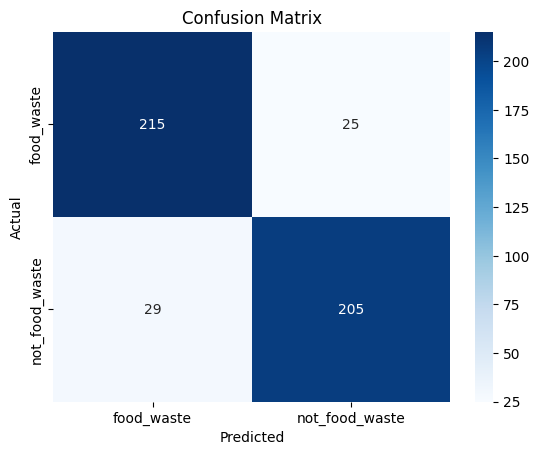

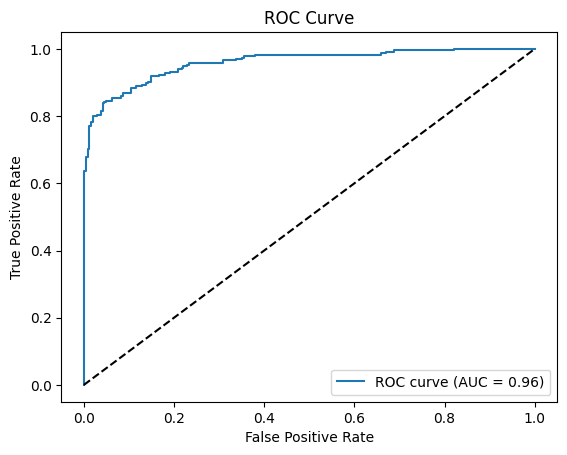

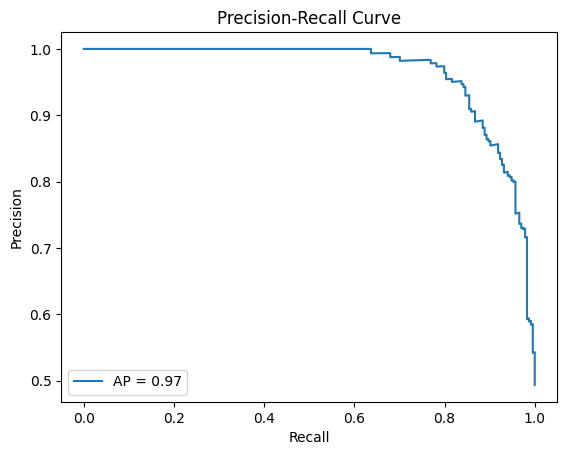

In [3]:
# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=['food_waste', 'not_food_waste']))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['food_waste', 'not_food_waste'], yticklabels=['food_waste', 'not_food_waste'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(true_labels, preds)
ap = average_precision_score(true_labels, preds)
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()